In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

import json
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# For data processing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [2]:
df = pd.read_csv('phl_exoplanet_catalog_2019.csv')
df.head()

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,...,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,11 Com b,3.0,6165.86330,-476.74200,476.74200,NaN,NaN,NaN,2007,2014-05-14,...,0,Hot,0,0.083813,Coma Berenices,Com,Berenice's Hair,12.082709,6165.86330,1.29
1,11 UMi b,3.0,4684.78480,-794.57001,794.57001,NaN,NaN,NaN,2009,2018-09-06,...,0,Hot,0,0.082414,Ursa Minor,UMi,Little Bear,12.229641,4684.78480,1.53
2,14 And b,3.0,1525.57440,NaN,NaN,NaN,NaN,NaN,2008,2014-05-14,...,0,Hot,0,0.081917,Andromeda,And,Andromeda,12.848516,1525.57440,0.83
3,14 Her b,3.0,1481.07850,-47.67420,47.67420,NaN,NaN,NaN,2002,2018-09-06,...,0,Cold,0,0.145241,Hercules,Her,Hercules,12.865261,1481.07850,2.93
4,16 Cyg B b,3.0,565.73385,-25.42624,25.42624,NaN,NaN,NaN,1996,2018-09-06,...,1,Warm,0,0.368627,Cygnus,Cyg,Swan,13.421749,565.73385,1.66


In [3]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4048 entries, 0 to 4047
Columns: 112 entries, P_NAME to P_SEMI_MAJOR_AXIS_EST
dtypes: float64(94), int64(4), object(14)
memory usage: 3.5+ MB


(4048, 112)

In [4]:
df.isnull().sum().sum()

149723

#### 453,376 total data points
#### 149,723 null data points
#### about 33.02% of our data is null values

#### we need to deal with all these null values
#### https://git.txstate.edu/ML/2022Fall/blob/main/project/examples/FeatureSelectionAndModeling.ipynb
#### method for dealing with null values

#### data normalization might be needed for some of these values, such as p_mass, since the range of values is large
#### this might cause our model to put more weight on planets with a larger mass (drowns out low mass planets data points)

In [5]:
df.fillna(df.mean(),inplace=True)

df.isnull().sum().sum()

/var/folders/xm/xp_mvznj0rs3thk9f6s1nx400000gn/T/ipykernel_38168/1673558777.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.mean(),inplace=True)


31494

In [6]:
df = df.dropna(axis = 1)
df.isnull().sum().sum()

0

In [7]:
df.shape

(4048, 101)

#### Dropped all the columns that were unable to be given values, 19 columns were dropped

#### https://datascienceparichay.com/article/get-correlation-between-columns-of-pandas-dataframe/
#### we will find correlation between p_habitable and each matrix, rather than a corr_matrix of 112 columns 

In [8]:
# Commented out temporarily (Takes longer time to run graphs)
corr_matrix = df.corr()
# plt.figure(figsize=(18,12))
# sns.heatmap(corr_matrix, cmap = 'Greens', annot = True)

#### the correlation matrix is too large to interpret, will need to run correlation between matricies individually

In [9]:
corr_habitable = corr_matrix['P_HABITABLE']
corr_habitable = corr_habitable.dropna()
corr_habitable = corr_habitable.abs()
corr_habitable = corr_habitable.drop('P_HABITABLE')
corr_habitable = corr_habitable.sort_values()

In [10]:
top10 = corr_habitable.tail(10)
top25 = corr_habitable.tail(25)

In [11]:
print(top10)

S_METALLICITY       0.092922
S_AGE               0.110499
S_TIDAL_LOCK        0.136728
P_TEMP_EQUIL_MIN    0.140296
P_TEMP_EQUIL        0.141131
P_TPERI             0.141285
P_TEMP_EQUIL_MAX    0.142674
P_HABZONE_CON       0.298875
P_ESI               0.427036
P_HABZONE_OPT       0.491481
Name: P_HABITABLE, dtype: float64


In [12]:
print(top25)

S_HZ_OPT_MAX                0.049386
S_HZ_CON1_MAX               0.049387
S_HZ_CON0_MAX               0.049387
S_HZ_CON_MAX                0.049387
P_OMEGA_ERROR_MAX           0.049910
S_DISTANCE                  0.051299
S_HZ_CON0_MIN               0.051827
S_HZ_CON1_MIN               0.051897
S_HZ_CON_MIN                0.051900
S_HZ_OPT_MIN                0.051901
S_SNOW_LINE                 0.055036
P_ECCENTRICITY_ERROR_MAX    0.074497
P_RADIUS_EST                0.076826
S_MASS                      0.083176
S_TEMPERATURE               0.090243
S_METALLICITY               0.092922
S_AGE                       0.110499
S_TIDAL_LOCK                0.136728
P_TEMP_EQUIL_MIN            0.140296
P_TEMP_EQUIL                0.141131
P_TPERI                     0.141285
P_TEMP_EQUIL_MAX            0.142674
P_HABZONE_CON               0.298875
P_ESI                       0.427036
P_HABZONE_OPT               0.491481
Name: P_HABITABLE, dtype: float64


<AxesSubplot:>

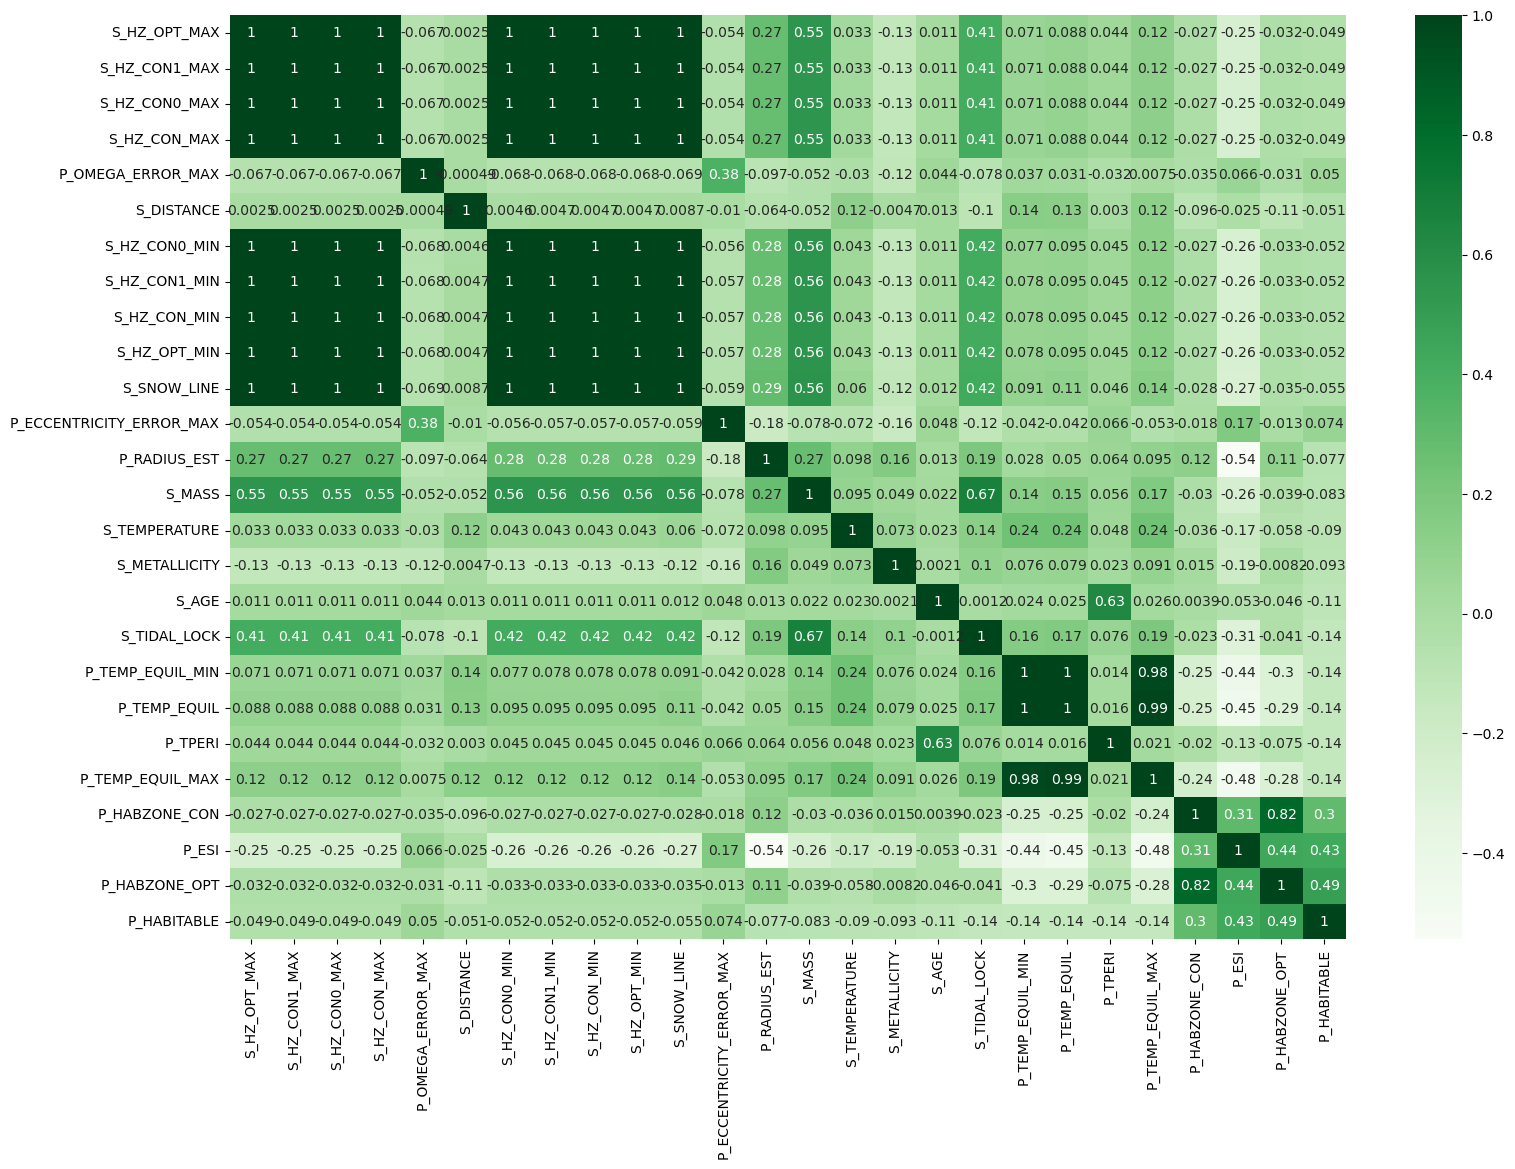

In [13]:
df_top25 = df[['S_HZ_OPT_MAX','S_HZ_CON1_MAX','S_HZ_CON0_MAX','S_HZ_CON_MAX','P_OMEGA_ERROR_MAX','S_DISTANCE',
               'S_HZ_CON0_MIN','S_HZ_CON1_MIN','S_HZ_CON_MIN','S_HZ_OPT_MIN','S_SNOW_LINE',
               'P_ECCENTRICITY_ERROR_MAX','P_RADIUS_EST','S_MASS','S_TEMPERATURE','S_METALLICITY','S_AGE',
               'S_TIDAL_LOCK','P_TEMP_EQUIL_MIN','P_TEMP_EQUIL','P_TPERI','P_TEMP_EQUIL_MAX','P_HABZONE_CON',        
               'P_ESI','P_HABZONE_OPT','P_HABITABLE']].copy()
corr_matrix3 = df_top25.corr()
plt.figure(figsize=(18,12))
sns.heatmap(corr_matrix3, cmap = 'Greens', annot = True)

In [14]:
df_top25.describe()

,S_HZ_OPT_MAX,S_HZ_CON1_MAX,S_HZ_CON0_MAX,S_HZ_CON_MAX,P_OMEGA_ERROR_MAX,S_DISTANCE,S_HZ_CON0_MIN,S_HZ_CON1_MIN,S_HZ_CON_MIN,S_HZ_OPT_MIN,...,S_AGE,S_TIDAL_LOCK,P_TEMP_EQUIL_MIN,P_TEMP_EQUIL,P_TPERI,P_TEMP_EQUIL_MAX,P_HABZONE_CON,P_ESI,P_HABZONE_OPT,P_HABITABLE
count,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,...,4.048000e+03,4048.000000,4048.000000,4048.000000,4.048000e+03,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000
mean,2.369724,2.246710,2.246710,2.246710,41.399581,631.067197,1.327826,1.211666,1.255196,0.990972,...,-2.114702e+06,0.440103,793.683032,804.193202,2.429249e+06,824.937273,0.034091,0.261252,0.049654,0.021986
std,3.898505,3.696113,3.696113,3.696113,20.909826,806.879393,2.099086,1.913314,1.981959,1.564722,...,4.771603e+07,0.066876,440.580213,440.561371,8.584848e+04,443.343275,0.181485,0.125915,0.217256,0.195731
min,0.001991,0.001887,0.001887,0.001887,0.000000,1.300000,0.000989,0.000900,0.000932,0.000736,...,-2.147484e+09,0.030707,2.688197,2.688197,0.000000e+00,2.688197,0.000000,0.006768,0.000000,0.000000
25%,1.232108,1.168150,1.168150,1.168150,41.399581,158.390000,0.688835,0.628499,0.651041,0.513990,...,-2.114702e+06,0.431567,488.025017,496.869857,2.429249e+06,508.670425,0.000000,0.209726,0.000000,0.000000
50%,1.760229,1.668857,1.668857,1.668857,41.399581,481.000000,1.001186,0.913776,0.946585,0.747324,...,2.000000e-03,0.440103,779.363265,787.461780,2.429249e+06,798.610855,0.000000,0.262866,0.000000,0.000000
75%,2.369724,2.246710,2.246710,2.246710,41.399581,864.732500,1.327826,1.211666,1.255196,0.990972,...,4.070000e+00,0.462869,1009.901075,1020.259725,2.429249e+06,1037.714125,0.000000,0.299152,0.000000,0.000000
max,77.651759,73.620449,73.620449,73.620449,354.300000,8500.000000,41.689213,37.995806,39.358419,31.072681,...,1.490000e+01,1.322542,7056.775700,7056.775700,2.464881e+06,7056.775700,1.000000,0.931208,1.000000,2.000000


In [15]:
objects = df.select_dtypes(include=['object'])
no_objects = df.select_dtypes(exclude=['object'])
no_objects.head()

,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_PERIOD,P_PERIOD_ERROR_MIN,...,S_SNOW_LINE,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_HABITABLE,P_ESI,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,3.0,6165.86330,-476.742000,476.742000,4.191426,-0.48399,0.621867,2007,326.03000,-0.32,...,34.529063,0.476460,0.642400,0,0,0,0.083813,12.082709,6165.86330,1.29
1,3.0,4684.78480,-794.570010,794.570010,4.191426,-0.48399,0.621867,2009,516.21997,-3.20,...,42.732816,0.193891,0.648683,0,0,0,0.082414,12.229641,4684.78480,1.53
2,3.0,1525.57440,-152.292232,190.289692,4.191426,-0.48399,0.621867,2008,185.84000,-0.23,...,20.593611,0.502752,0.600010,0,0,0,0.081917,12.848516,1525.57440,0.83
3,3.0,1481.07850,-47.674200,47.674200,4.191426,-0.48399,0.621867,2002,1773.40000,-2.50,...,2.141648,0.919756,0.445415,0,0,0,0.145241,12.865261,1481.07850,2.93
4,3.0,565.73385,-25.426240,25.426240,4.191426,-0.48399,0.621867,1996,798.50000,-1.00,...,3.019411,1.983658,0.473325,1,1,0,0.368627,13.421749,565.73385,1.66


In [16]:
objects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4048 entries, 0 to 4047
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   P_NAME               4048 non-null   object
 1   P_UPDATED            4048 non-null   object
 2   P_DETECTION          4048 non-null   object
 3   S_NAME               4048 non-null   object
 4   S_ALT_NAMES          4048 non-null   object
 5   S_RA_T               4048 non-null   object
 6   S_DEC_T              4048 non-null   object
 7   S_CONSTELLATION      4048 non-null   object
 8   S_CONSTELLATION_ABR  4048 non-null   object
 9   S_CONSTELLATION_ENG  4048 non-null   object
dtypes: object(10)
memory usage: 316.4+ KB


#### Here we are checking the columns that contain objects to see if the data is worth encoding.

In [17]:
objects['P_DETECTION'].value_counts()

Transit                          3114
Radial Velocity                   765
Microlensing                       78
Imaging                            47
Transit Timing Variations          18
Eclipse Timing Variations          11
Orbital Brightness Modulation       6
Pulsar Timing                       6
Pulsation Timing Variations         2
Astrometry                          1
Name: P_DETECTION, dtype: int64

In [18]:
objects['S_RA_T'].value_counts()

18 57 44.0416    8
23 06 29.2875    7
19 48 27.6332    6
19 44 27.0191    6
23 13 16.9820    6
                ..
18 56 23.4372    1
19 43 33.0061    1
19 18 59.3590    1
19 45 13.9115    1
12 20 43.0286    1
Name: S_RA_T, Length: 3010, dtype: int64

In [19]:
objects['S_DEC_T'].value_counts()

+49 18 18.5796    8
-05 02 28.5864    7
+41 54 32.8968    6
+39 58 43.6044    6
+57 10 06.0744    6
                 ..
+47 48 38.2968    1
+43 09 21.8268    1
+39 31 24.4848    1
+43 49 16.8600    1
+17 47 34.3248    1
Name: S_DEC_T, Length: 3010, dtype: int64

#### The previous three columns do not seem like good candidates for encoding.

In [20]:
objects['S_CONSTELLATION'].value_counts()

Cygnus                 1371
Lyra                    880
Virgo                   158
Draco                   154
Aquarius                 93
                       ... 
Apus                      2
Crux                      2
Triangulum Australe       2
Corona Australis          2
Sagitta                   2
Name: S_CONSTELLATION, Length: 88, dtype: int64

In [21]:
objects['S_CONSTELLATION_ABR'].value_counts()

Cyg    1371
Lyr     880
Vir     158
Dra     154
Aqr      93
       ... 
Aps       2
Cru       2
TrA       2
CrA       2
Sge       2
Name: S_CONSTELLATION_ABR, Length: 88, dtype: int64

In [22]:
objects['S_CONSTELLATION_ENG'].value_counts()

Swan                 1371
Lyre                  880
Virgin                158
Dragon                154
Water Carrier          93
                     ... 
Bird of Paradise        2
Southern Cross          2
Southern Triangle       2
Southern Crown          2
Arrow                   2
Name: S_CONSTELLATION_ENG, Length: 88, dtype: int64

#### The previous three object columns represent the same data. Encoding one of these columns may be a good idea.

In [23]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
objects.iloc[:, 7] = le.fit_transform(objects.iloc[:, 7])

In [24]:
objects['S_CONSTELLATION'].value_counts()

30    1371
51     880
85     158
33     154
3       93
      ... 
2        2
29       2
80       2
25       2
70       2
Name: S_CONSTELLATION, Length: 88, dtype: int64

In [25]:
df['P_HABITABLE'].corr(objects['S_CONSTELLATION'])

-0.009034930834177406

#### The 'S_CONSTELLATION' column does not have a strong correlation with habitability.

In [26]:
df['P_HABITABLE'].value_counts()

0    3993
2      34
1      21
Name: P_HABITABLE, dtype: int64

In [27]:
# Commented out temporarily (Takes longer time to run graphs)
#sns.pairplot(df_top25)

In [28]:
# Commented out temporarily (Takes longer time to run graphs)
#sns.pairplot(df_top25.iloc[:,16:26])

#### We may want to combine values 2 & 1 or eliminate one from the 'P_HABITABLE' column so that we can use logistic regression at some point. 

<AxesSubplot:xlabel='S_TIDAL_LOCK', ylabel='P_HABITABLE'>

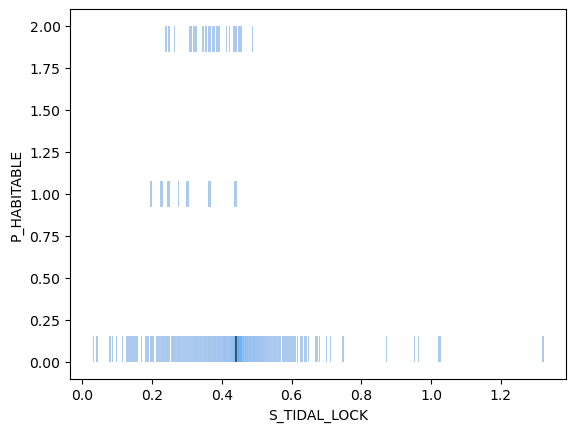

In [29]:
sns.histplot(data = df_top25, x ='S_TIDAL_LOCK',y = 'P_HABITABLE')

In [30]:
y=df_top25['P_HABITABLE']

x=df_top25.drop(['P_HABITABLE'],axis=1).copy()

In [31]:
scaler = StandardScaler()
scaler.fit(x)
x= scaler.fit_transform(x)

In [32]:
# scaler = StandardScaler()
# scaler.fit(x)
# y= scaler.fit_transform(y)

In [33]:
xtrain, xtest, ytrain, ytest =  train_test_split(x,y, test_size = 0.2, random_state=42, stratify=y)

In [34]:
from sklearn.linear_model import LogisticRegression

clf=LogisticRegression()
clf.fit(xtrain,ytrain)

#print score for test data
print(clf.score(xtest,ytest))

0.9950617283950617


/Users/benjaminprentice/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


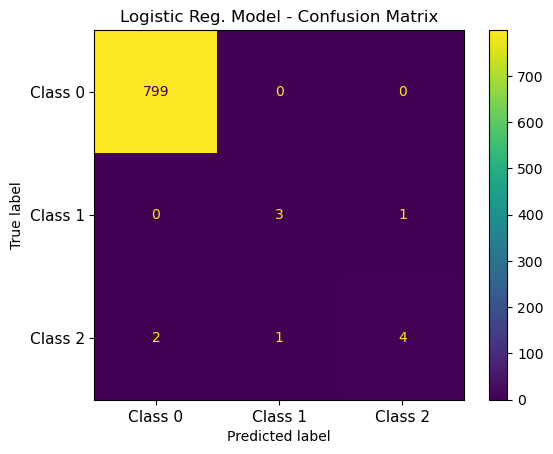

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = ConfusionMatrixDisplay.from_estimator(clf,xtest, ytest)
plt.title("Logistic Reg. Model - Confusion Matrix")
plt.xticks(range(3), ["Class 0","Class 1", "Class 2"], fontsize=11)
plt.yticks(range(3), ["Class 0","Class 1", "Class 2"], fontsize=11)
plt.show()

#### This is a very bad model. The habitability classes 1 & 2 are predicted inaccurately. The true positives of inhabitability skew the accuracy score.

In [36]:
# Removing data columns that are related to each other in the correlation matrix
skim_data = df_top25.copy()
skim_data = skim_data.drop(['S_HZ_OPT_MAX','S_HZ_CON1_MAX', 'S_HZ_CON0_MAX', 'S_HZ_CON_MAX',
                            'S_HZ_CON0_MIN', 'S_HZ_CON1_MIN', 'S_HZ_CON_MIN', 'S_HZ_OPT_MIN',
                            'P_TEMP_EQUIL_MIN', 'P_TEMP_EQUIL_MAX'], axis = 1)

In [37]:
# In the P_HABITABLE feature, there are values of [0,1,2]
# not habitable      = 0
# kind of habitable  = 1
# very habitable     = 2
# For the sake of this project, we could have labels 1 and 2 be equivalent for binary classification

#skim_data['P_HABITABLE'] = skim_data['P_HABITABLE'].replace(2,1)
#skim_data['P_HABITABLE'].value_counts()

In [38]:
y2=skim_data['P_HABITABLE']
x2=skim_data.drop(['P_HABITABLE'],axis=1).copy()

# Balancing data values (Imbalanced data shown above)
ROS = RandomOverSampler(random_state=42,sampling_strategy='auto')
x_res, y_res = ROS.fit_resample(x2,y2)
# plt.hist(y_res)

print(y_res.value_counts())

0    3993
2    3993
1    3993
Name: P_HABITABLE, dtype: int64


/Users/benjaminprentice/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Cross-validation scores: [0.67779633 0.67195326 0.6836394  0.34557596 0.65859766 0.69949917
 0.34390651 0.34307179 0.75041736 0.71261487 0.34808013 0.67863105
 0.67278798 0.68280467 0.65776294 0.68948247 0.67028381 0.64774624
 0.57762938 0.67335004 0.67612688 0.67195326 0.34808013 0.67445743
 0.34390651 0.65358932 0.34474124 0.64691152 0.71035058 0.68421053]
Average cross-validation score: 0.60


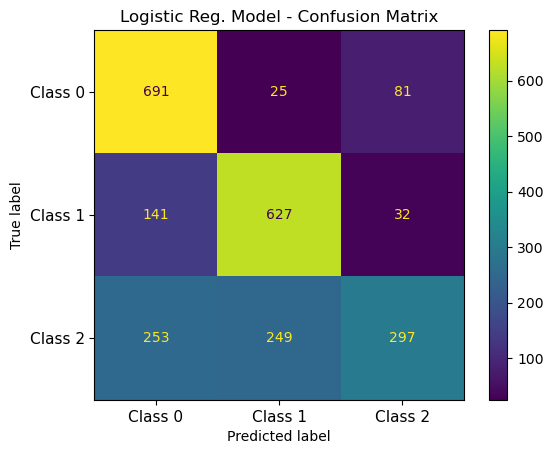

In [39]:
scaler = StandardScaler()
scaler.fit(x2)
x2 = scaler.fit_transform(x2)


x2train, x2test, y2train, y2test =  train_test_split(x_res,y_res, test_size = 0.2, random_state=42)


clf2=LogisticRegression(class_weight = 'balanced' )

clf2.fit(x2train,y2train)


###

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(clf2, x_res, y_res, cv=cv, n_jobs=-1)

print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format( ( (scores.sum())/scores.size )  ))


###

#print score for test data
#print(clf.score(xtest,ytest))

cm2 = ConfusionMatrixDisplay.from_estimator(clf2,x2test, y2test)
plt.title("Logistic Reg. Model - Confusion Matrix")
plt.xticks(range(3), ["Class 0","Class 1", "Class 2"], fontsize=11)
plt.yticks(range(3), ["Class 0","Class 1", "Class 2"], fontsize=11)
plt.show()

In [40]:
# weights = {0:0.01, 1:1.0}
# model = LogisticRegression(solver='lbfgs', class_weight=weights)
# # define evaluation procedure
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# # evaluate model
# scores = cross_val_score(model, x, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# # summarize performance
# print('Mean ROC AUC: %.3f' % mean(scores))

Model accuracy score with default hyperparameters: 0.9950


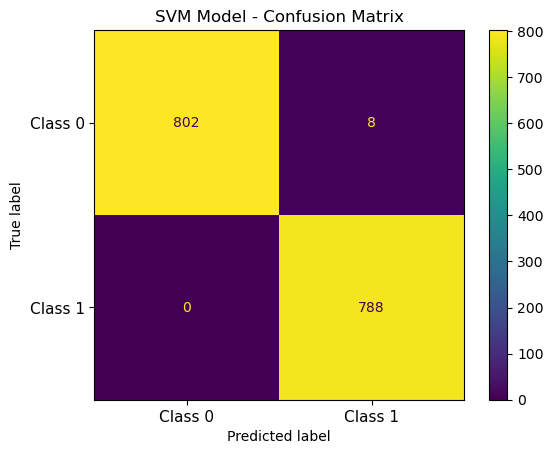

In [41]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

y3 = skim_data['P_HABITABLE'].replace(2,1)

ROS = RandomOverSampler(random_state=42,sampling_strategy='auto')
x_res, y_res = ROS.fit_resample(x2,y3)

x3train, x3test, y3train, y3test =  train_test_split(x_res,y_res, test_size = 0.2, random_state=42)

svc=SVC() 

# fit classifier to training set
svc.fit(x3train,y3train)

# make predictions on test set
y_pred=svc.predict(x3test)


# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y3test, y_pred)))

cm3 = ConfusionMatrixDisplay.from_estimator(svc, x3test, y3test)
plt.title("SVM Model - Confusion Matrix")
plt.xticks(range(2), ["Class 0","Class 1"], fontsize=11)
plt.yticks(range(2), ["Class 0","Class 1"], fontsize=11)
plt.show()